# Credit Card Fraud Detection
## Wykrywanie oszustw związanych z kartami kredytowymi


Analizie zostanie poddany zbiór danych zawierający transakcje dokonane kartami kredytowymi we wrześniu 2013r. przez europejczyków w ciągu 2 dni.

Celem zadania jest:

     1) Dokonaj eksploracyjnej analizy danych oraz opisz wnioski i obserwacje;
     2) Stwórz model predykcyjny, który w skuteczny sposób będzie wskazywał podejrzane transakcje;
     3) Dokonać analizy wyników 
     
 Dane pobrane ze strony: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Library - biblioteki 
Wszystkie biblioteki potrzebne do prawidłowego działania kodu znajdują się tutaj.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

import time
import warnings
warnings.filterwarnings("ignore")

## 1) Introduction - Wprowadzenie 

Na podstawie informacji znajdujących się przy danych wiemy, że tabela zawiera 31 kolumn z pośród których możemy wyszczególnić: 
    - Time - liczba sekund, która upłyneła między badaną tranzakcją a pierwszą transakcją w zestawieniu;
    - Amount - kwota tranzakcji;
    - Class - 1 w przypadku oszustwa, 0 w pozostałych przypadkach
    - V1-V28 - przeskalowane, nieopisane dane w celu ochrony danych osobowych (PCA)
I każda z kolumn zawiera 284807 wierszy.

### Defined function 

In [13]:
def draw_histogram(data, title, size=(12,5), bins=50):
    '''
    EN: Function to plot histogram
    PL: Funkcja do rysowania histogramów
    
    Parameters
    ----------
        data: array, data to visualisation
        title: (str) title of figure
        size: size window, default=(12,5)
        bins: number of column in histogram, default=50
    '''       
    fig, ax = plt.subplots(figsize=size)
    sns.distplot(data, ax=ax, bins=bins)
    ax.set_title(title)
    ax.set_xlim([min(data), max(data)])
    plt.show() 

In [14]:
def draw_double_histogram(data, features, size=(12,5), bins=50):
    '''
    EN: Function to plot histogram
    PL:Funkcja do rysowania histogramów
    
    Parameters
    ----------
        data: array, data to visualisation
        features: array, name of column to draw
        size: size window, default=(12,5)
        bins: number of column in histogram, default=50
    ''' 
    plt.figure(figsize=(12,len(features)*4))
    gs = gridspec.GridSpec(len(features), 1)
    for i, col in enumerate(df[features]):
        ax = plt.subplot(gs[i])
        sns.distplot(data[col][df.Class == 1], bins=bins)
        sns.distplot(data[col][df.Class == 0], bins=bins)
        ax.set_xlabel('')
        ax.set_title('Histogram of feature: ' + str(col))
#         ax.set_xlim([min(data[col]), max(data[col])])
    plt.show()   

In [26]:
def PRcurve(y_true, y_pred, plotting = False, returnAuc = True):
    """
    Takes arguments data and scores and plots PR-curve for model scores.
    y_true - true values of y
    y_pred - predicted probabilities
    """
    from sklearn.metrics import precision_recall_curve
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    if plotting == True:
        plt.plot(precision, recall)
        plt.title("PR curve")
        plt.xlabel("Precision")
        plt.ylabel("Recall")
    auc = round(np.dot(np.abs(recall[1:]-recall[0:-1]),precision[1:]),3)
    if returnAuc == True:
        return(auc) #return Area under the PR Curve

## 2) First look on the data - Podstawowa analiza danych 
### Podsumowanie zdobytych informacji
    1) Rozmiar danych 284807 wierszy, 31 kolumn
    2) 369(0.1723%) transakcje to oszustwa, a pozostałe 213236(99.823%) transakcji to prawidłowe transakcje
    3) Dane nie zawierają żadnych wybrakowanych wartości.
    4) Analiza histogramu oraz boxplota dla zmiennej "Amount" wynika, że mamy doczynienia z bardzo dużą liczbą małych tranzakcji
    5) Analiza histogramu dla zmiennej "Time" można zauważyć, że podczas dnia jest wykonywane zdecydowanie więcej tranzakcji niż nocą;
    6) Macierz korelacji pokazała, że żadna z kolumn nie jest na tyle skorelowana z Klasą, żeby brać ją pod uwagę.

#### Załadowanie danych 

In [2]:
df = pd.read_csv("Data/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,...,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,...,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,...,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,...,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,...,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0


In [5]:
df.shape

(213605, 31)

#### Opis prawidłowych tranzakcji i oszustw

In [6]:
df_no_flaud = df[df.Class == 0]
df_no_flaud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,...,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.000000,213236.0
mean,94786.243031,0.008700,-0.007108,0.011439,-0.007749,0.005386,0.001118,0.008590,-0.000097,0.006494,...,-0.001318,0.000866,-0.000858,0.000104,0.000700,0.000212,-0.000577,-0.000331,88.370575,0.0
std,47516.732944,1.932303,1.641687,1.461015,1.396272,1.344550,1.322137,1.160517,1.159179,1.088899,...,0.709891,0.723788,0.631372,0.605749,0.521792,0.482457,0.397534,0.327838,248.770228,0.0
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-24.419483,-50.943369,-6.105803,...,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.0
25%,54134.750000,-0.917112,-0.598840,-0.885849,-0.847214,-0.691370,-0.766993,-0.553128,-0.208859,-0.637090,...,-0.228277,-0.541214,-0.161788,-0.353587,-0.316987,-0.327070,-0.070982,-0.052864,5.640000,0.0
50%,84637.000000,0.021871,0.063949,0.182722,-0.021399,-0.054197,-0.273933,0.041551,0.022081,-0.047329,...,-0.029570,0.007524,-0.011905,0.041216,0.017393,-0.052409,0.001054,0.011199,22.000000,0.0
75%,139289.000000,1.316146,0.800371,1.029865,0.737537,0.611986,0.399322,0.569882,0.326033,0.600271,...,0.185799,0.527658,0.146643,0.439272,0.351985,0.241060,0.090298,0.077843,77.000000,0.0
max,172792.000000,2.451888,18.902453,9.382558,16.875344,34.801666,23.917837,44.054461,18.709255,15.594995,...,22.588989,8.272233,20.803344,4.016342,7.519589,3.517346,12.152401,33.847808,19656.530000,0.0


In [7]:
df_flaud = df[df.Class == 1]
df_flaud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,...,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0
mean,81742.769648,-4.586912,3.607730,-6.839043,4.405857,-3.091104,-1.360680,-5.422950,0.484907,-2.545094,...,0.766251,0.013921,0.081441,-0.104428,0.050772,0.047553,0.148435,0.084942,110.438157,1.0
std,48471.700261,6.694782,4.312807,6.931307,2.849054,5.274777,1.850759,7.181037,7.064123,2.501627,...,4.067469,1.550562,1.114900,0.530055,0.770953,0.480527,1.332533,0.518405,221.502314,0.0
min,406.000000,-29.876366,-8.402154,-30.558697,-1.313275,-21.665654,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-5.988806,-2.028024,-2.167510,-1.152671,-7.263482,-1.796363,0.000000,1.0
25%,41313.000000,-5.839192,1.189757,-8.451410,2.230778,-4.409844,-2.445140,-7.281328,-0.164910,-3.838399,...,0.105593,-0.531496,-0.304666,-0.434643,-0.325033,-0.263934,-0.019579,-0.098173,1.000000,1.0
50%,75033.000000,-2.303350,2.708535,-5.111658,4.028391,-1.433055,-1.419748,-3.005953,0.672409,-2.042416,...,0.594623,0.043807,-0.041461,-0.060327,0.068951,-0.002601,0.389152,0.144774,9.820000,1.0
75%,129308.000000,-0.361428,4.864535,-2.220907,6.320089,0.175739,-0.411924,-0.974073,1.869838,-0.788388,...,1.242896,0.624207,0.320133,0.298242,0.456090,0.400348,0.782036,0.383869,105.990000,1.0
max,170348.000000,2.132386,22.057729,2.250210,11.864868,9.880564,6.474115,5.802537,19.587773,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.156042,2.745261,2.352333,1.773326,2125.870000,1.0


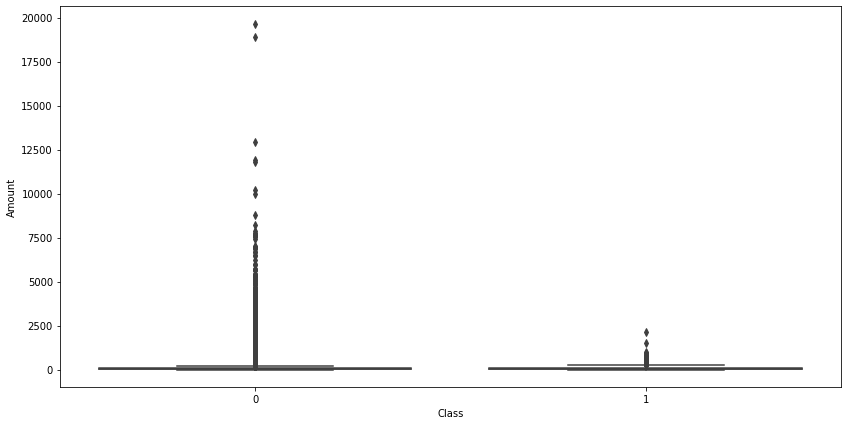

In [8]:
plt.figure(figsize=(14,7))
sns.boxplot(x='Class', y='Amount', data=df)

#### Ilość oszustw 

In [9]:
df.Class.value_counts()

0    213236
1       369
Name: Class, dtype: int64

#### Procentowa ilość oszustw 

In [10]:
print(df.Class.value_counts()[0]/len(df))
print(df.Class.value_counts()[1]/len(df))

0.9982725123475574
0.0017274876524425926


#### Ilość outliers

In [11]:
df.isnull().sum().any()

False

### Histogram cen tranzakcji

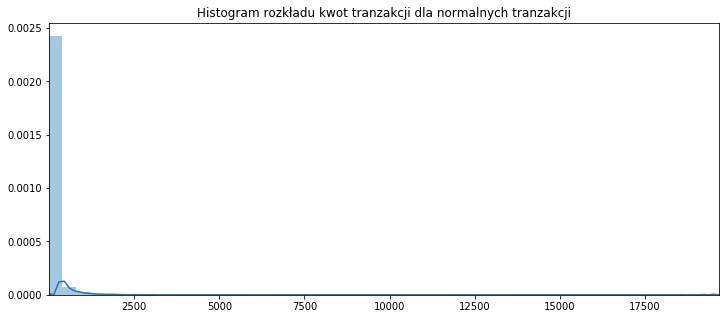

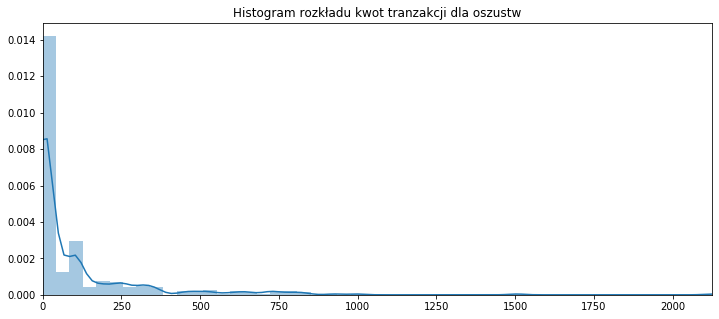

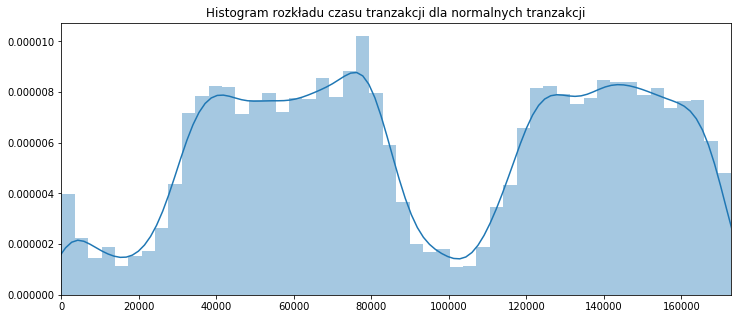

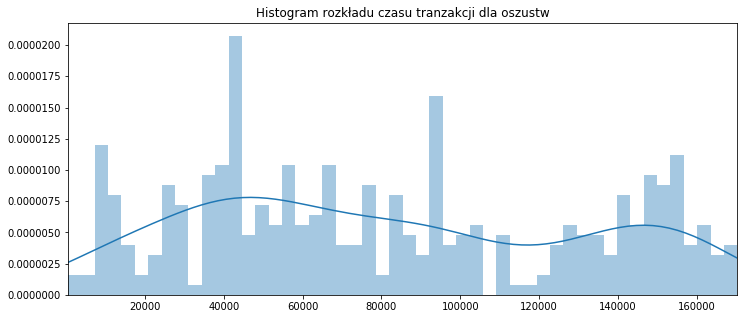

In [28]:
draw_histogram(df[df.Class == 0].Amount.values, 
               'Histogram rozkładu kwot tranzakcji dla normalnych tranzakcji', bins=50)
draw_histogram(df[df.Class == 1].Amount.values, 
               'Histogram rozkładu kwot tranzakcji dla oszustw', bins=50)
draw_histogram(df[df.Class == 0].Time.values, 
               'Histogram rozkładu czasu tranzakcji dla normalnych tranzakcji', bins=50)
draw_histogram(df[df.Class == 1].Time.values, 
               'Histogram rozkładu czasu tranzakcji dla oszustw', 
               bins=50)

#### Macierz korelacji 

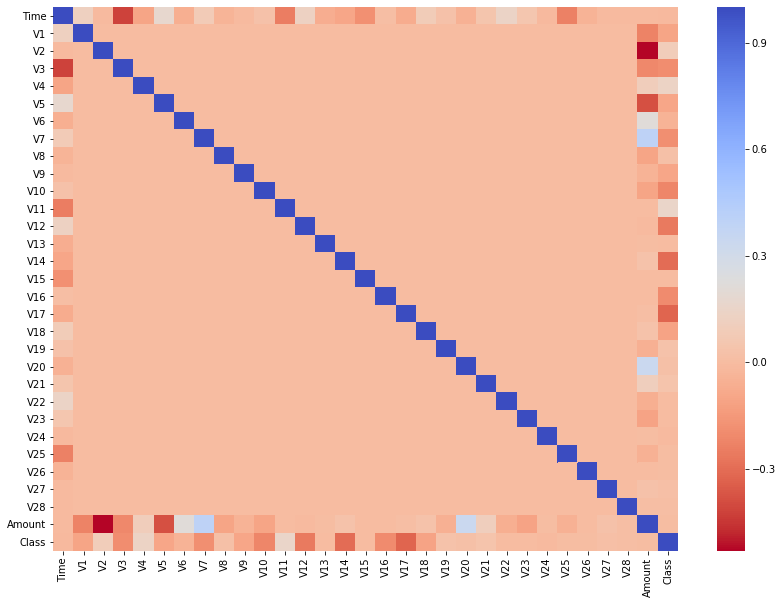

In [13]:
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

### Analiza kolumn 

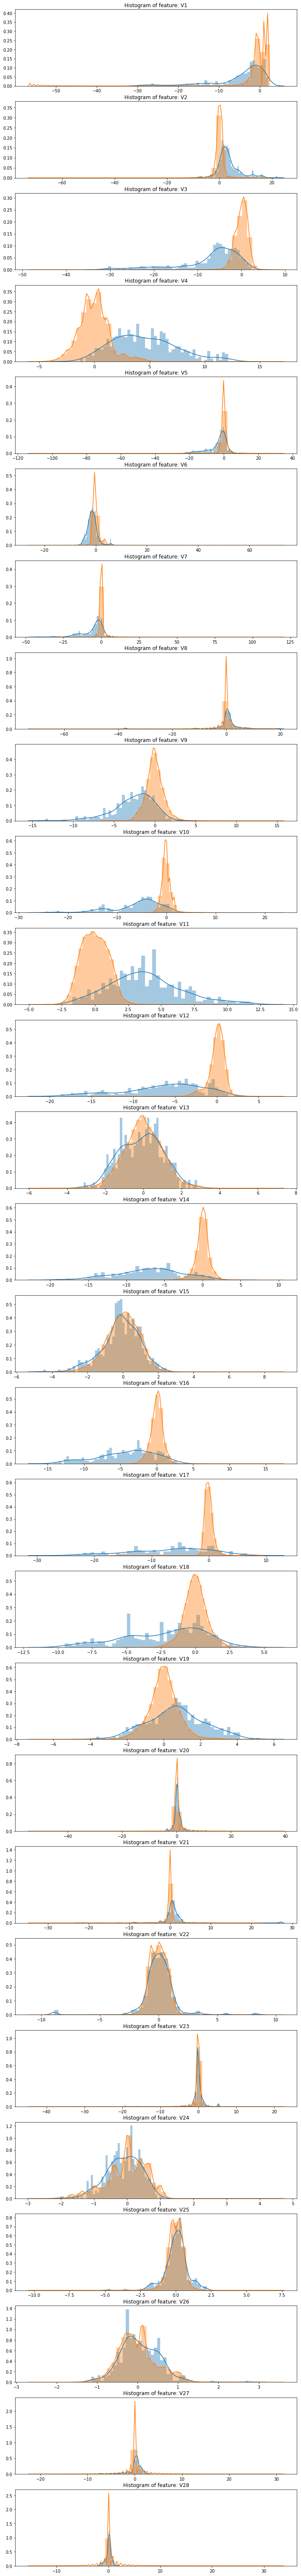

In [15]:
features = df.ix[:,1:29].columns
draw_double_histogram(df, features)

## 3) Preprocessing data 

W tej części skupie się na następujących działaniach:

    1) Przeskalowanie wartości kwot i czasu - ponieważ nasze niewiadome 28 kolumn jest również przeskalowane, to ta czynność jest aż konieczna;
    2) Dostosowanie wielkości danych do wielkości zbioru oszustw - masz mode musi mieć jednakowe szanse na nauczenie się co jest oszustwem, a co nie
    3) Przygotowanie zbiorów treningowych i walidacyjnych

#### Skalowanie zmiennych

In [17]:
df = df[df.Amount > 0]
df.Amount = np.log(df.Amount)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time,Scaler_CV
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583,0.003834
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583,-0.019692
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562,0.041916
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562,-0.000399
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541,-0.009002


### Przekształcenie czasu na godziny 

In [ ]:
df["Hour"] = np.mod(np.ceil(df.Time/3600),24) #return hour of the day
df.drop(['Time'], axis=1, inplace=True)
df.head()

#### Dzielenie danych 

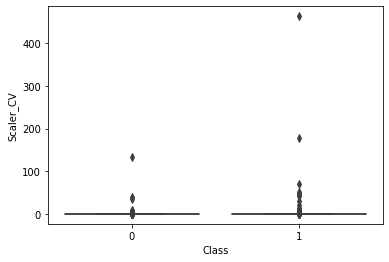

In [18]:
sns.boxplot(x='Class', y="Scaler_CV", data=df)

In [19]:
df_sample = df.sample(frac=1)

fraud_df = df_sample[df_sample.Class == 1]
non_fraud_df = df_sample[df_sample.Class == 0]
non_fraud_df = non_fraud_df[:492]
new_df = pd.concat([fraud_df, non_fraud_df])

print(new_df.shape)

new_df.head()

(984, 32)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time,Scaler_CV
135718,-0.885254,1.790649,-0.945149,3.853433,-1.543510,0.188582,-2.988383,1.344059,-2.294535,-1.886176,...,-0.034882,-0.567608,-0.528318,0.258782,0.506893,0.176736,1,-0.322964,-0.283058,-0.002005
118308,-0.430330,0.985633,0.645789,0.317131,0.616332,-1.347462,1.078234,-0.161518,-0.492856,-1.039638,...,-0.164119,0.255280,0.454798,-0.505032,-0.039456,-0.006358,1,-0.232727,-0.416544,0.054500
9252,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-3.179949,-9.252794,4.245062,-6.329801,-13.136698,...,-0.310804,-1.201685,1.352176,0.608425,1.574715,0.808725,1,-0.349231,-1.716028,-0.017748
100623,-0.758469,-0.045410,-0.168438,-1.313275,-1.901763,0.739433,3.071892,-0.483422,0.618203,-1.769060,...,0.072229,-0.242276,0.560916,-0.540955,0.150606,-0.117140,1,1.841960,-0.573678,3.285436
229730,1.894036,1.905806,-3.515730,4.508913,2.044466,-1.420468,1.057480,-0.281157,-1.832604,-0.628463,...,-0.101530,-0.414960,0.376597,0.150778,-0.013712,0.048084,1,-0.344354,1.078421,-0.014848


#### Ja teraz prezentuje się nasza macierz korelacji? 

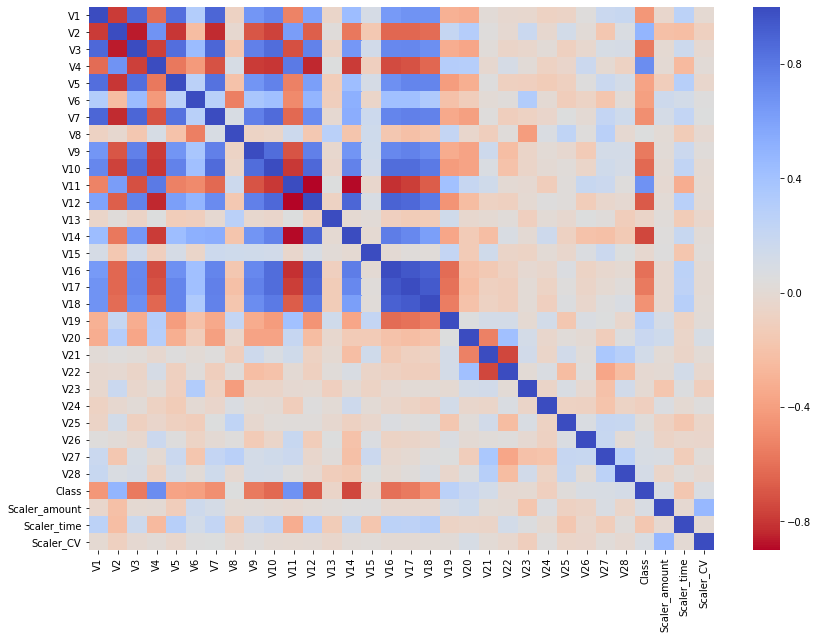

In [20]:
plt.figure(figsize=(14,10))
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

Można zauważyć, że teraz kolumny V4, V11 są skorelowane negarywnie, natomiast V9, V10, V12, V14 i V16 są skorelowane pozytywnie z kolumną Klasy(oszustw).

##  Classifiers - Klasyfikatory

### Przygotowanie zbiorów do uczenia 

In [46]:
X_data = new_df.drop('Class', axis=1)
y_data = new_df.Class

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=24601)

### Logistic Regression - Regresja logistyczna
#### Training score

In [47]:
classifier = LogisticRegression(random_state=24601)
classifier.fit(X_train, y_train)
training_score_lr = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = {:.4f} %".format(training_score_lr.mean()*100))

Training score = 94.9085 %


#### Confusion matrix

In [23]:
y_pred_lr = classifier.predict(X_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_lr

array([[132,   5],
       [ 11, 148]], dtype=int64)

####  Looking for the best parameter

In [24]:
lr_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 "penalty": ['l1', 'l2']}
grid_lr = GridSearchCV(classifier, lr_parameters)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=24601, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
best_log_regression = grid_lr.best_estimator_
best_log_regression

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=24601, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
log_regression_score = cross_val_score(best_log_regression, X_train, y_train, cv=5)
print('Logistic Regression -> Cross Validation Score: ', 
      round(log_regression_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression -> Cross Validation Score:  95.34%


### K nearest neighbours - K najbliższych sąsiadów
#### Training score

In [27]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
training_score_knears = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", 
      round(training_score_knears.mean(),5)*100, '% accuracy')

Training score =  94.619 % accuracy


#### Confusion_matrix

In [28]:
y_pred_knears = classifier.predict(X_test)
conf_matrix_knears = confusion_matrix(y_test, y_pred_knears)
conf_matrix_knears

array([[133,   4],
       [ 15, 144]], dtype=int64)

####  Looking for the best parameter

In [29]:
knears_parameters = {"n_neighbors": [2,3,4,5,6,7], 
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(classifier, knears_parameters)
grid_knears.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
best_knears = grid_knears.best_estimator_
best_knears

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
knears_score = cross_val_score(best_knears, X_train, y_train, cv=5)
print('K Nearest Neighbours -> Cross Validation Score: ', 
      round(knears_score.mean() * 100, 2).astype(str) + '%')

K Nearest Neighbours -> Cross Validation Score:  94.62%


### Decision Tree  - Drzewa decyzyjne
#### Training score

In [32]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
training_score_tree = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", 
      round(training_score_tree.mean(),2)*100, '% accuracy')

Training score =  92.0 % accuracy


#### Confusion_matrix

In [33]:
y_pred_tree = classifier.predict(X_test)
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_tree

array([[121,  16],
       [  7, 152]], dtype=int64)

#### Looking for the best parameter

In [34]:
tree_parameters = {"criterion": ["gini", "entropy"], 
                   "max_depth": list(range(2,9,1))}
grid_tree = GridSearchCV(classifier, tree_parameters)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
best_trees = grid_tree.best_estimator_
best_trees

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
tree_score = cross_val_score(best_trees, X_train, y_train, cv=5)
print('Decision Tree -> Cross Validation Score: ', 
      round(tree_score.mean() * 100, 2).astype(str) + '%')

Decision Tree -> Cross Validation Score:  92.88%


## Analysis and summary of collected results - Analiza i podsumowanie zebranych wyników 


### Training Score,  Cross validation score, 

In [37]:
print('% '*40)
print(' '*10)
print("For Logistic Regression, we got:")
print(' '*10)
print('Training score: {:.4f} %'.format(training_score_lr.mean()*100))
print('Cross validation score: {:.4f} %'.format(log_regression_score.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_test, y_pred_lr)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_test, y_pred_lr)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_test, y_pred_lr)*100))
print(' '*10)
print('% '*40)
print(' '*10)
print("For K nearest neighbours, we got:")
print(' '*10)
print('Training score: {:.4f} %'.format(training_score_knears.mean()*100))
print('Cross validation score: {:.4f} %'.format(knears_score.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_test, y_pred_knears)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_test, y_pred_knears)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_test, y_pred_knears)*100))
print(' '*40)
print('% '*40)
print(' '*10)
print("For Decision Tree, we got:")
print(' '*10)
print('Training score: {:.4f} %'.format(training_score_tree.mean()*100))
print('Cross validation score: {:.4f} %'.format(tree_score.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_test, y_pred_tree)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_test, y_pred_tree)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_test, y_pred_tree)*100))
print(' '*10)
print('% '*40)

% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Logistic Regression, we got:
          
Training score: 94.9085 %
Cross validation score: 95.3433 %
Recall Score: 93.0818 %
Precision Score: 96.7320 %
F1 Score: 94.8718 %
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For K nearest neighbours, we got:
          
Training score: 94.6186 %
Cross validation score: 94.6186 %
Recall Score: 90.5660 %
Precision Score: 97.2973 %
F1 Score: 93.8111 %
                                        
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Decision Tree, we got:
          
Training score: 92.4394 %
Cross validation score: 92.8753 %
Recall Score: 95.5975 %
Precision Score: 90.4762 %
F1 Score: 92.9664 %
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 


### Confusion matrix

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          size=5):
    """
    EN: Function to print and plot a confusion matrix
    PL: Funkcja do plotowania tablicy pomyłek 
    
    Parameters
    ----------
        cm: confusion matrix
        classes: type of category
        normalize=False: normalization of number, if you want it, write True
        title: str, title of figure
        cmap: palet of colours
        size: int, width of squere window
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(size,size))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

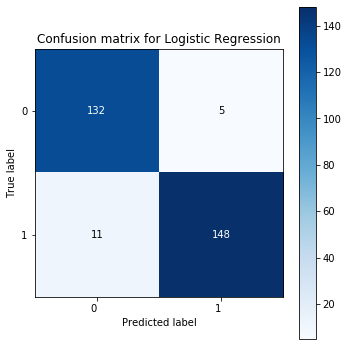

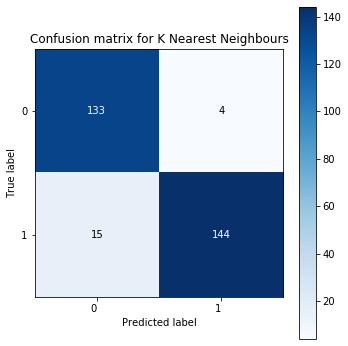

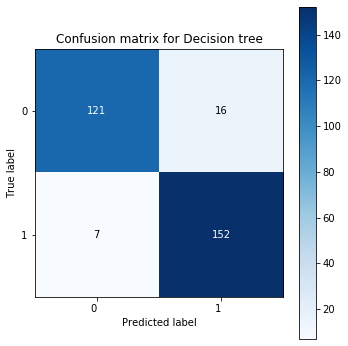

In [39]:
plot_confusion_matrix(conf_matrix_lr, classes=[0,1], 
                      title='Confusion matrix for Logistic Regression')
plot_confusion_matrix(conf_matrix_knears, classes=[0,1], 
                      title='Confusion matrix for K Nearest Neighbours')
plot_confusion_matrix(conf_matrix_tree, classes=[0,1], 
                      title='Confusion matrix for Decision tree')

### Learning curve 

In [40]:
def plot_learning_curve(model, X_data, y_data, cv, 
                        title, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5),
                        size=(12,5)):
    '''
    EN: Function for drawing a learning curve for training results and cross-validation.
    PL: Funkcja do rysowanie krzywej uczenia dla wyników treninowych oraz cross-validation.
    
    Parameters
    -----------
        model: fitting classifier
        X_data: dataset, with parameters for model
        y_data: dataset, with solution
        cv: int, cross-validation generator or an iterable
        n_jobs: int, Number of jobs to run in parallel
        train_sizes: array, Relative or absolute numbers of training 
                    examples that will be used to generate the learning curve
        size: (int,int), size of figure
    '''
    plt.figure(figsize=(size))
    plt.ylim = (0.80, 1.01)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_data, y_data, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    plt.title(title)
    plt.xlabel('Training size')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc="best")

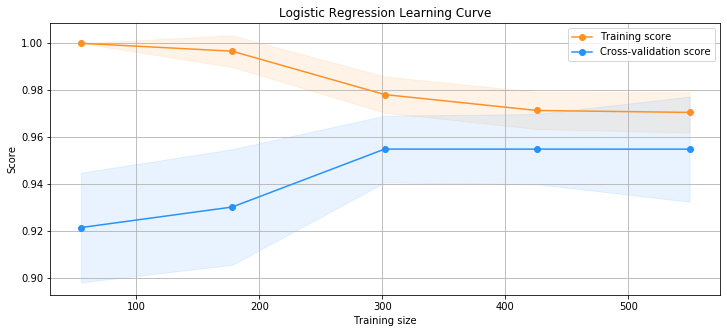

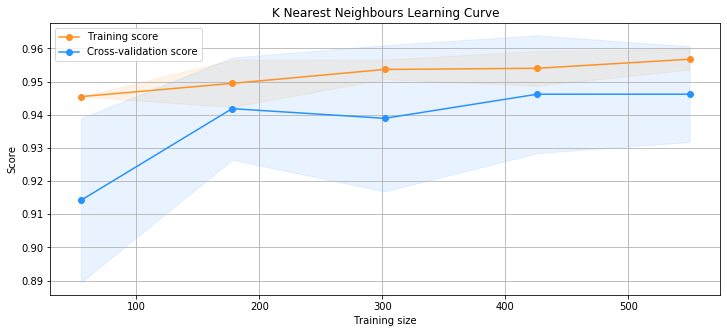

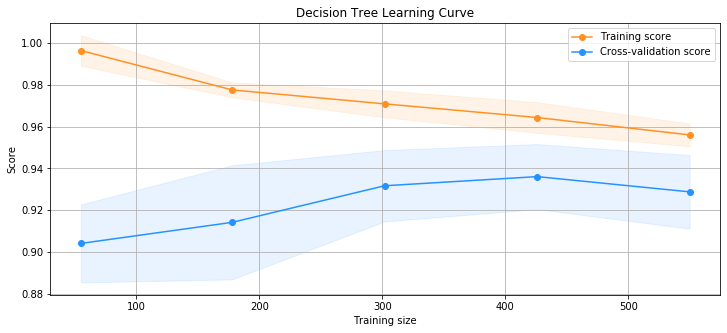

In [41]:
plot_learning_curve(best_log_regression, X_train, y_train, cv=5, title='Logistic Regression Learning Curve')
plot_learning_curve(best_knears, X_train, y_train, cv=5, title='K Nearest Neighbours Learning Curve')
plot_learning_curve(best_trees, X_train, y_train, cv=5, title='Decision Tree Learning Curve')

### ROC_curve 

In [42]:
def plot_roc_curve(vec_fpr, vec_tpr, vec_label, 
                   vec_roc_auc, title='ROC Curve'):
    '''
    EN: Function to plot many roc_curve on one figure
    PL: Funkcja do rysowania wielu roc_curve na jednym wykresie
    
    Parameters
    ----------
        vec_fpr: array, vector with fpr (false positive rate) for each models
        vec_tpr: array, vector with tpr (true positive rate) for each models
        vec_label: array of str, name models
        vec_roc_aus: array, values roc_auc for each models
        title: str, title of figure 'ROC Curve \n Top 4 Classifiers'
    '''
    plt.figure(figsize=(14,10))
    plt.title(title)
    
    for id_model in range(len(vec_label)):
        plt.plot(vec_fpr[id_model], vec_tpr[id_model], 
                 label=vec_label[id_model] + ' Classifier Score: {:.4f}'.format(vec_roc_auc[id_model]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
                 xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    plt.show()

In [43]:
log_reggresion_pred = cross_val_predict(best_log_regression, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(best_knears, X_train, y_train, cv=5)

tree_pred = cross_val_predict(best_trees, X_train, y_train, cv=5)

In [44]:
vec_pred = [log_reggresion_pred, knears_pred, tree_pred]

vec_fpr = []
vec_tpr = [] 
vec_roc_aus = []

for pred in vec_pred:
    fpr, tpr, thresold = roc_curve(y_train, pred)
    vec_fpr.append(fpr)
    vec_tpr.append(tpr)
    roc_aus = roc_auc_score(y_train, pred)
    vec_roc_aus.append(roc_aus)

vec_label = ['Logistic Regresion', 'K Nearest Neighbours', 'Desition tree']

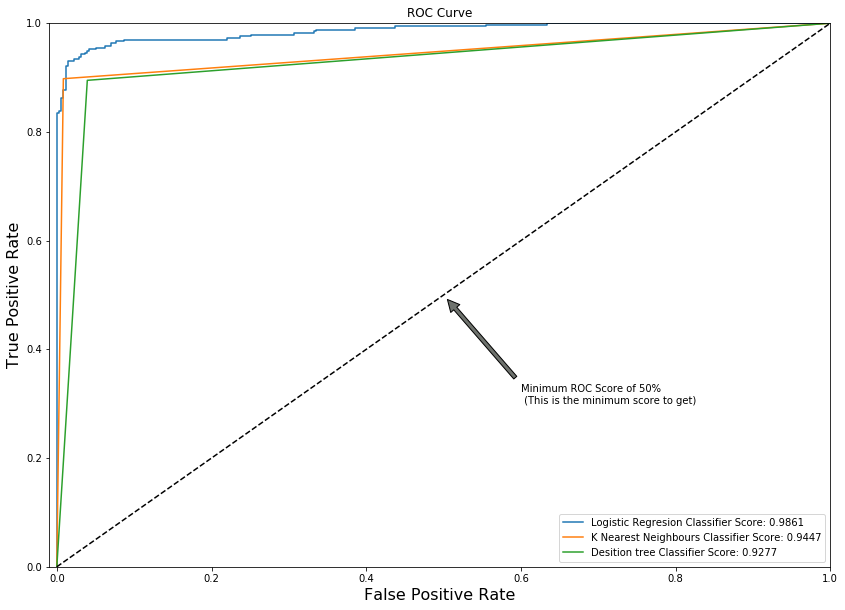

In [45]:
plot_roc_curve(vec_fpr, vec_tpr, vec_label, vec_roc_aus)

## Analiza jakości nauczonego modelu dla nieobrobionych danych

In [48]:
X_test = df.drop('Class', axis=1)
y_test = df.Class

y_pred_lr_old = classifier.predict(X_test)
conf_matrix_lr_old = confusion_matrix(y_test, y_pred_lr_old)

log_regression_score_old = cross_val_score(best_log_regression, X_train, y_train, cv=5)

print('% '*40)
print(' '*10)
print("For Logistic Regression, we got:")
print(' '*10)
print('Cross validation score: {:.4f} %'.format(log_regression_score_old.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_test, y_pred_lr_old)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_test, y_pred_lr_old)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_test, y_pred_lr_old)*100))
print(' '*10)
print('% '*40)

% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Logistic Regression, we got:
          
Cross validation score: 95.3433 %
Recall Score: 93.6992 %
Precision Score: 7.4874 %
F1 Score: 13.8667 %
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 


## Analiza jakości modelu uczącego się na nieprzerobionych dancyh 

In [49]:
X_data = df.drop('Class', axis=1)
y_data = df.Class

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=24601)

classifier = LogisticRegression(random_state=24601)
%time classifier.fit(X_train, y_train)

y_pred_lr_old = classifier.predict(X_test)
conf_matrix_lr_old = confusion_matrix(y_test, y_pred_lr_old)

log_regression_score_old = cross_val_score(best_log_regression, X_train, y_train, cv=5)

print('% '*40)
print(' '*10)
print("For Logistic Regression, we got:")
print(' '*10)
print('Cross validation score: {:.4f} %'.format(log_regression_score_old.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_test, y_pred_lr_old)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_test, y_pred_lr_old)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_test, y_pred_lr_old)*100))
print(' '*10)
print('% '*40)

% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Logistic Regression, we got:
          
Cross validation score: 99.9278 %
Recall Score: 59.6491 %
Precision Score: 89.4737 %
F1 Score: 71.5789 %
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 


# Conclusions - wnioski
    1) Z przeprowadzonych analiz wychodzi, że każda z metod ma swoje dobre strony:
    - Regresja logistyczna charakteryzuje się największą skutecznością, F1 Score oraz krzywa ROC i ROC_AUC jest największe;
    - K najbliższych sąsiadów uzyskało najlepsze wyniki dla Precision Score;
    - Drzewa decyzyjne uzyskały najlepszy Recall Score.
    2) Jednakże regresja logistyczna posiada najlepsze wyniki zarówno dla krzywej treningowej jak i walidacyjnej(krzyżowej)
    3) Zmniejszenie ilości dancy w celu wyrównania zbiorów uczących było dobrym posunięciem, gdyż skuteczność oraz Recall mamy dalej na bardzo wysokim poziomie, ale pozostałe współczynniki badania jakości modelu spadły poniżej 15%
    4) Uczenie modelu na nieobrobionych danych było bardzo specyficzne wyniki: uczenie było bardzo czasochłonne, skuteczność była na lepszym poziomie nić w modelu z obrobionymi danymi, ale pozostałe współczynniki były sporo niższe to skutkowało tym, że model nie był najlepszy do prawidłowego wskazywania oszustw.
    5) Dodanie współczynnika wartościowości spowodowało, że zmniejszył się FP(false positiwe), czyli jest mniejsza sansa na wykrycie oszustwa u niewinnej osoby